In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from aldiscore.prediction import utils
from aldiscore import ROOT

In [2]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, *_ = utils.load_features(
    data_dir,
    include_features=["is_dna", "num_seqs", "seq_length"],
)
# feat_df.columns = clean_feat_names

feat_df = feat_df[["is_dna", "num_seqs", "max.seq_length"]]
feat_df.head()

Dropping 0 NaN rows...


is_dna  num_seqs  max.seq_length
source    dataset                                  
arthropod CYP_12    False       141             558
          CYP_15    False       148             524
          CYP_18    False       124             569
          CYP_2     False        16             544
          CYP_20    False        19             494

In [4]:
perf_dir = ROOT / "logs" / "perf"
perf_file = sorted(os.listdir(perf_dir))[-1]
print(perf_file)
perf_df = pd.read_parquet(perf_dir / perf_file)
# perf_df = pd.concat([perf_df, feat_df], axis=1)
perf_df

2025-10-06_08-33-28.parquet


_init_basics  \
source        dataset                                            
treebase_v1   14688_30.phy                            0.115430   
              14688_37.phy                            0.751806   
              18661_0.phy                             0.541347   
              21420_1.phy                             0.071750   
              21963_1.phy                             0.745272   
...                                                        ...   
bralibase_k15 tRNA.apsi-48.sci-130.no-1               0.001766   
              Retroviral_psi.apsi-91.sci-76.no-1      0.001862   
              tRNA.apsi-46.sci-136.no-1               0.001924   
              TAR.apsi-89.sci-89.no-1                 0.001725   
              SRP_bact.apsi-50.sci-92.no-1            0.001801   

                                                  _init_char_dists  _init_psa  \
source        dataset                                                           
treebase_v1   14688_30.phy                                0.000718   0.028640   
              14688_37.phy                                0.000682   0.026237   
              18661_0.phy                                 0.001328   0.030988   
              21420_1.phy                                 0.000386   0.024607   
              21963_1.phy                                 0.001035   0.026250   
...                                                            ...        ...   
bralibase_k15 tRNA.apsi-48.sci-130.no-1                   0.000234   0.015605   
              Retroviral_psi.apsi-91.sci-76.no-1          0.000288   0.022028   
              tRNA.apsi-46.sci-136.no-1                   0.000309   0.010718   
              TAR.apsi-89.sci-89.no-1                     0.000204   0.009245   
              SRP_bact.apsi-50.sci-92.no-1                0.000253   0.020452   

                                                  _init_psa_index_map  \
source        dataset                                                   
treebase_v1   14688_30.phy                                   0.001133   
              14688_37.phy                                   0.000504   
              18661_0.phy                                    0.002264   
              21420_1.phy                                    0.001903   
              21963_1.phy                                    0.002476   
...                                                               ...   
bralibase_k15 tRNA.apsi-48.sci-130.no-1                      0.004159   
              Retroviral_psi.apsi-91.sci-76.no-1             0.003918   
              tRNA.apsi-46.sci-136.no-1                      0.002928   
              TAR.apsi-89.sci-89.no-1                        0.003859   
              SRP_bact.apsi-50.sci-92.no-1                   0.004184   

                                                  _data_type  _num_sequences  \
source        dataset                                                          
treebase_v1   14688_30.phy                          0.000010        0.000007   
              14688_37.phy                          0.000045        0.000399   
              18661_0.phy                           0.000012        0.000008   
              21420_1.phy                           0.000302        0.000012   
              21963_1.phy                           0.000013        0.000009   
...                                                      ...             ...   
bralibase_k15 tRNA.apsi-48.sci-130.no-1             0.000003        0.000002   
              Retroviral_psi.apsi-91.sci-76.no-1    0.000003        0.000002   
              tRNA.apsi-46.sci-136.no-1             0.000002        0.000002   
              TAR.apsi-89.sci-89.no-1               0.000002        0.000002   
              SRP_bact.apsi-50.sci-92.no-1          0.000003        0.000002   

                                                  _sequence_length  \
source        dataset                                                
treeba

In [5]:
# Median execution time for all sources
perf_df.sum(axis=1).groupby("source").median().sort_values(ascending=False).to_frame().T

source,treebase_v1,prefab4,bali3,arthropod,bali2dna,bali2dnaf,bralibase_k15,formatt_sabmark,formatt_homstrad,bralibase_k7,ox,sabre,bralibase_k5
0,19.074487,2.844456,0.378443,0.35347,0.18192,0.165301,0.103453,0.066978,0.034587,0.031948,0.031143,0.030623,0.018791


In [20]:
import seaborn as sn
import matplotlib.pyplot as plt

heavy_cols = ["_init_psa"]
plot_df = perf_df[heavy_cols].copy()
plot_df.columns = ["PSA computation"]

drop_cols = heavy_cols + ["_ent_randomness"]
plot_df["rest"] = perf_df.drop(drop_cols, errors="ignore", axis=1).sum(axis=1)

input_sizes = (feat_df["num_seqs"] * feat_df["max.seq_length"]).loc[plot_df.index]
# input_sizes = (feat_df["num_seqs"]).loc[plot_df.index]
plot_df["input_size"] = input_sizes
psa_mask = plot_df["PSA computation"] <= plot_df["PSA computation"].quantile(0.99)
rest_mask = plot_df["rest"] <= plot_df["rest"].quantile(0.99)
plot_df = plot_df[psa_mask & rest_mask]
plot_df.shape

(11211, 3)

In [21]:
total = pd.cut(plot_df.sum(axis=1), bins=np.linspace(0, 250000, 20))

In [22]:
plot_df = plot_df.melt(
    id_vars=["input_size"],
    value_vars=["PSA computation", "rest"],
    var_name="aspect",
    value_name="time (s)",
)
plot_df

,input_size,aspect,time (s)
0,1188,PSA computation,0.028640
1,1028,PSA computation,0.026237
2,810,PSA computation,0.030988
3,1098,PSA computation,0.024607
4,432,PSA computation,0.026250
...,...,...,...
22417,1335,rest,0.099648
22418,1800,rest,0.086580
22419,1305,rest,0.090916
22420,855,rest,0.094460


<Axes: xlabel='input_size', ylabel='time (s)'>

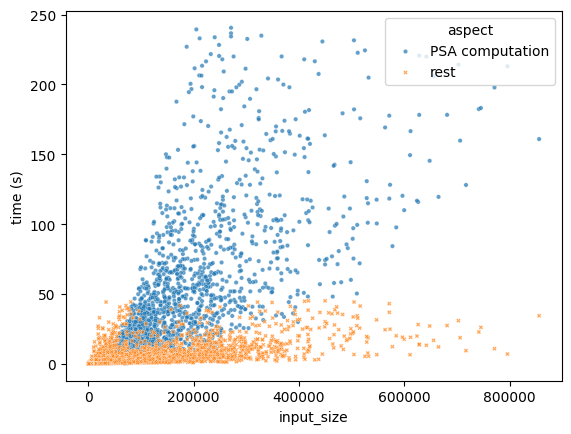

In [23]:
sn.scatterplot(
    data=plot_df,
    x="input_size",
    y="time (s)",
    hue="aspect",
    style="aspect",
    alpha=0.7,
    s=10,
)

/tmp/ipykernel_1489560/1984594484.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = plt.gca().set_xticklabels(xticklabels, rotation=45)


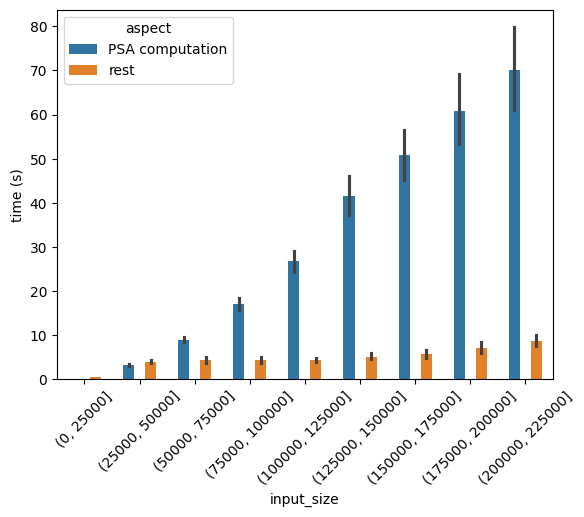

In [32]:
x = pd.cut(plot_df["input_size"], bins=np.arange(0, 250000, 25000))

sn.barplot(
    data=plot_df,
    x=x,
    y="time (s)",
    hue="aspect",
    gap=0.5,
    # flierprops={"marker": "x"},
)
xticklabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xticklabels, rotation=45)

/tmp/ipykernel_1489560/3529381834.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = plt.gca().set_xticklabels(xticklabels, rotation=45)


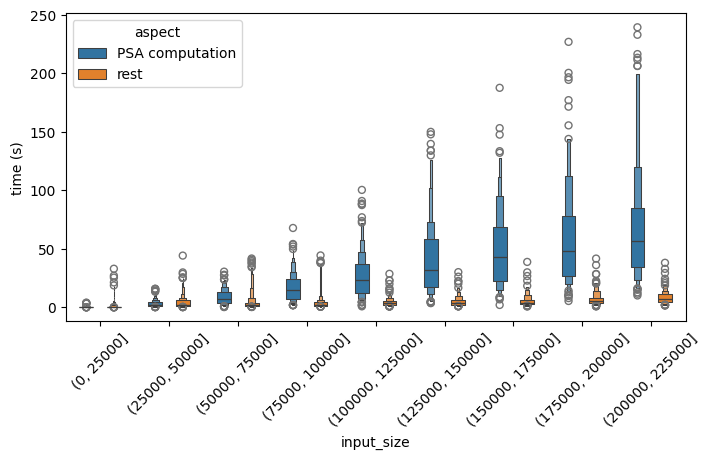

In [24]:
x = pd.cut(plot_df["input_size"], bins=np.arange(0, 250000, 25000))
fig = plt.figure(figsize=(8, 4))
sn.boxenplot(
    data=plot_df,
    x=x,
    y="time (s)",
    hue="aspect",
    gap=0.5,
    # flierprops={"marker": "x"},
)
# plt.yscale("log")
xticklabels = plt.gca().get_xticklabels()
_ = plt.gca().set_xticklabels(xticklabels, rotation=45)